<a href="https://colab.research.google.com/github/luanakwon/ML_Pytorch_pre2022/blob/main/AutoEncoder_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autoencoder structure hand-written number generator.  
(also tried to interpret the encoded latent space, but couldn't.)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

In [ ]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader 

In [ ]:
batch_size = 256
learning_rate = 0.0005
num_epoch = 20
KL_coef = 3
latent_dim = 6

In [ ]:
mt = dset.MNIST("drive/MyDrive/Dataset/",train=True, transform=transforms.ToTensor(),target_transform=None, download=False)
# mnist_test = dset.MNIST("./",train=False, transform=transforms.ToTensor(),target_transform=None, download=True)

train_loader = torch.utils.data.DataLoader(mt, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
# test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    
    self.layer = nn.Sequential(
        nn.Conv2d(1,32,3,1,1),
        nn.LeakyReLU(0.2,True), # 28
        nn.Conv2d(32,64,3,2,1),
        nn.LeakyReLU(0.2,True), # 14
        nn.Conv2d(64,64,3,2,1),
        nn.LeakyReLU(0.2,True), # 7
        nn.Conv2d(64,64,3,1,1),
        nn.LeakyReLU(0.2,True), # 7
        # nn.Conv2d(32,16,3,1,1),
        # nn.ReLU(True)  # 2
        nn.Flatten()
    )
    self.layer_G = nn.Linear(3136,latent_dim)
    self.layer_H = nn.Linear(3136,latent_dim)
  def forward(self,x):
    out = self.layer(x)
    G = self.layer_G(out)
    H = self.layer_H(out)
    return (G, H)



In [ ]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()

    self.layer_fc = nn.Linear(latent_dim,3136)
    self.layer = nn.Sequential(
        nn.ConvTranspose2d(64,64,3,1,1),
        nn.LeakyReLU(0.2,True), # 7
        nn.ConvTranspose2d(64,64,3,2,1,output_padding=1),
        nn.LeakyReLU(0.2,True), # 14
        nn.ConvTranspose2d(64,32,3,2,1,output_padding=1),
        nn.LeakyReLU(0.2,True), # 28
        nn.ConvTranspose2d(32,1,3,1,1),
        nn.Sigmoid()  # 28
    )

  def forward(self, x):
    out = self.layer_fc(x)
    out = self.layer(out.view(-1,64,7,7))
    return out


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

enc = Encoder().to(device)
dec = Decoder().to(device)

loss_cycle = nn.MSELoss(reduction='none')
#loss_KL = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.Adam(list(enc.parameters())+list(dec.parameters()),lr=learning_rate)

In [ ]:
LC = []
LKL = []
for e in range(num_epoch):
  for j, (image, label) in enumerate(train_loader):
    image = image.to(device)

    optimizer.zero_grad()
    G, H = enc.forward(image)
    G = G.view(batch_size, -1)
    H = H.view(batch_size, -1)
    n = torch.randn_like(G)
    z = (torch.exp(H/2)*n+G)
    gen = dec.forward(z)

    l1 = loss_cycle(image,gen)
    l1 = l1.view(batch_size,-1).sum(axis=1).mean()
    l2 = - torch.sum(1+H-G*G-torch.exp(H),axis=1) * 0.5 
    l2 = l2.mean() * KL_coef
    loss = l1+l2
    loss.backward()
    optimizer.step()

    LC.append(l1.data)
    LKL.append(l2.data)
    if j%10 == 0:
      print(f'\rEpoch {e} Batch {j} loss {LC[-1]} , {LKL[-1]}',end='')

Epoch 19 Batch 230 loss 29.897628784179688 , 12.918148040771484

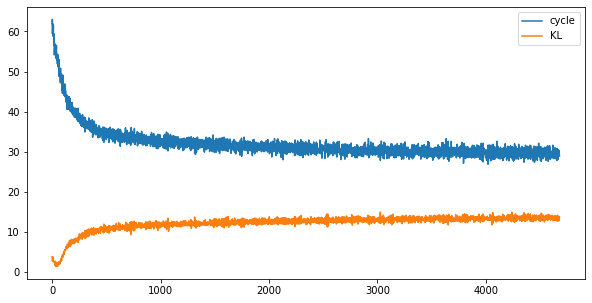

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#print(LC)
plt.figure(figsize=(10,5))
plt.plot(LC,label='cycle')
plt.plot(LKL, label='KL')
plt.legend()
plt.show()

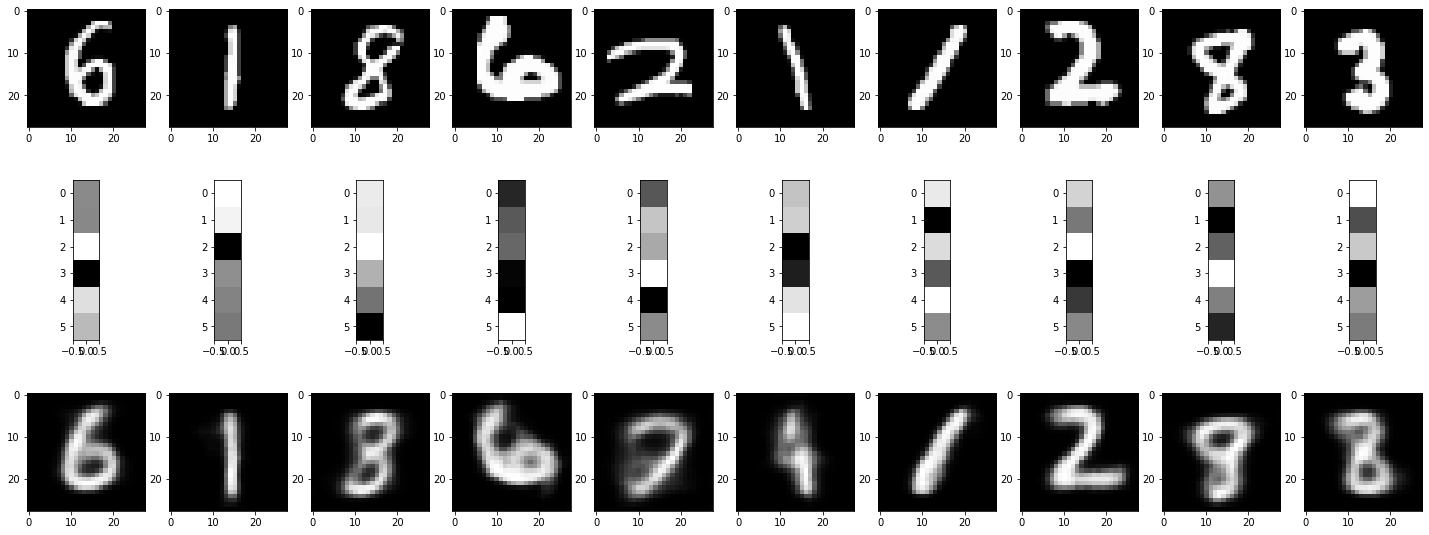

In [ ]:
with torch.no_grad():
  for image, label in train_loader:
    image = image.to(device)
    G, H = enc.forward(image)
    G = G.view(batch_size, -1)
    H = H.view(batch_size, -1)
    n = init.normal_(torch.zeros_like(G))
    feature = (torch.exp(H/2)*n+G)
    out = dec.forward(feature)
    feature = feature * 0.5 + 0.5

    plt.figure(figsize=(25,10))
    for i in range(10):
      plt.subplot(3,10,i+1)
      plt.imshow(image.cpu().detach().numpy()[i][0],cmap='gray')
    for i in range(10):
      plt.subplot(3,10,i+11)
      plt.imshow(feature.cpu().detach().view(batch_size,1,latent_dim,1).numpy()[i][0],cmap='gray')
    for i in range(10):
      plt.subplot(3,10,i+21)
      plt.imshow(out.cpu().detach().numpy()[i][0],cmap='gray')

    break

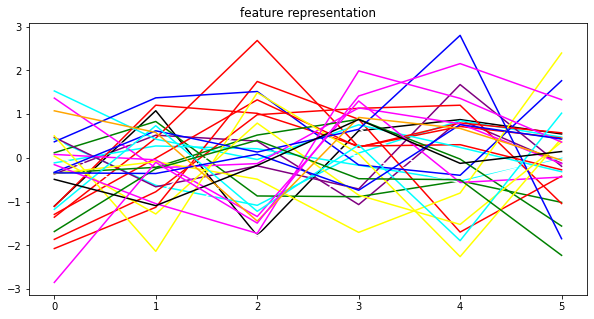

In [ ]:
COLOR = ['red','orange','yellow','green','cyan','blue','purple','magenta','white','black']

with torch.no_grad():
  for image, label in train_loader:
    image = image.to(device)
    G, H = enc.forward(image)
    G = G.view(batch_size, -1)
    H = H.view(batch_size, -1)
    n = torch.randn_like(G)
    feature = torch.exp(H/2)*n + G
    f = feature.cpu().detach().numpy()
    plt.figure(figsize=(10,5))
    plt.title('feature representation')
    for i in range(30):
      plt.plot(f[i],color=COLOR[int(label[i])])

    plt.show()
    break


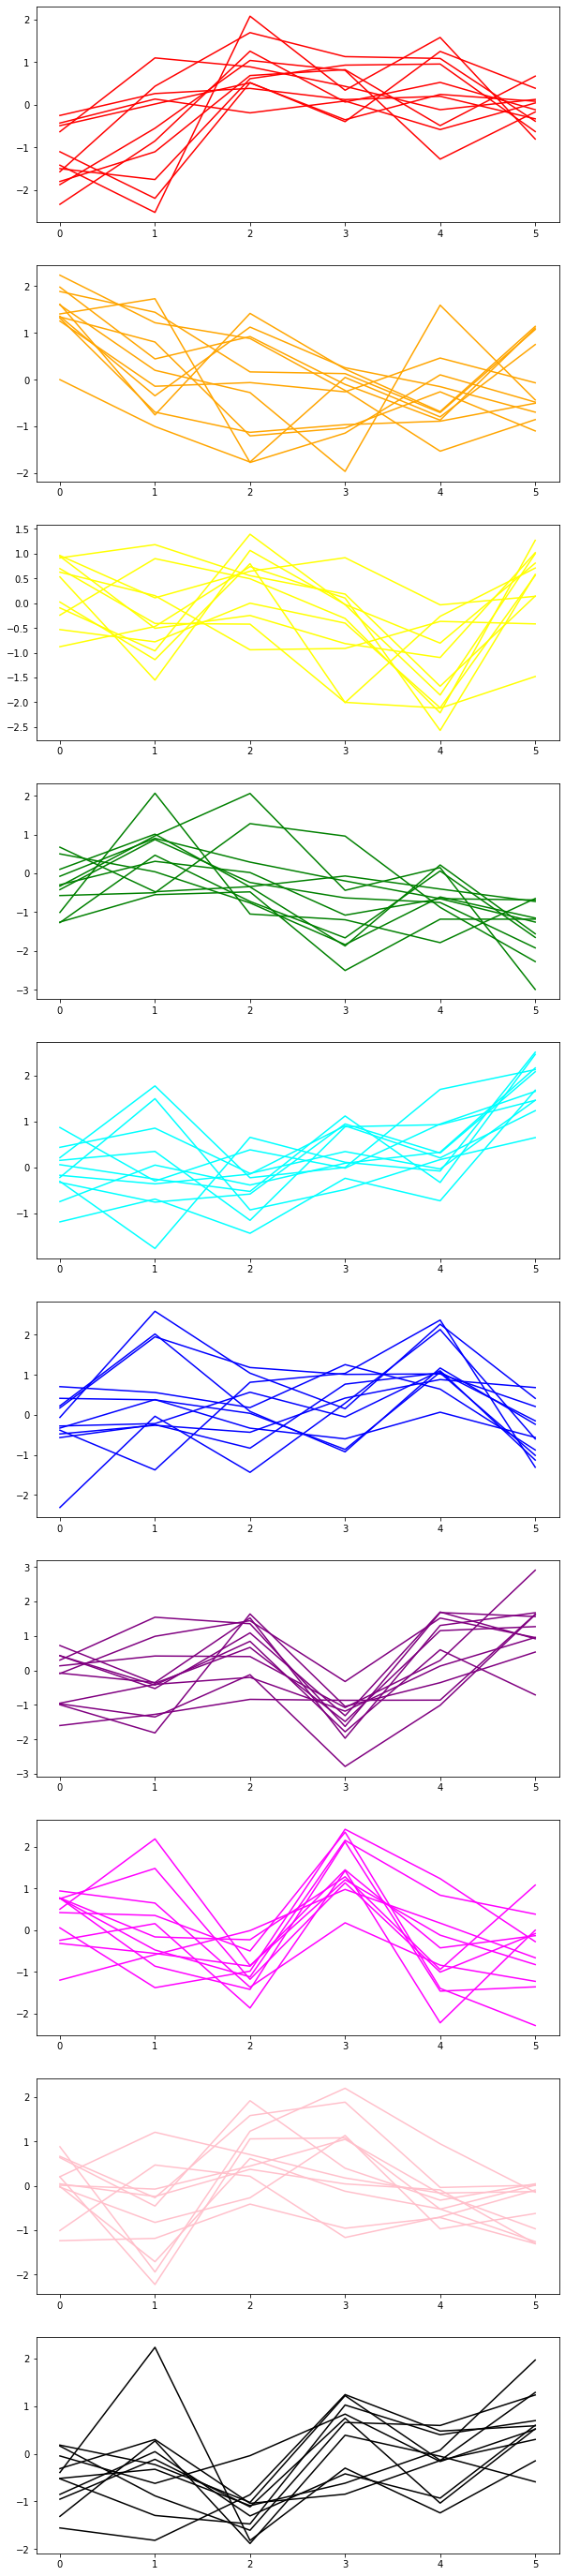

In [ ]:
COLOR = ['red','orange','yellow','green','cyan','blue','purple','magenta','pink','black']

with torch.no_grad():
  plt.figure(figsize=(10,50))
  plt.title('feature representation')
  i = 0
  count = 0
  plt.subplot(10,1,1)
  done = False
  for image, label in train_loader:
    image = image.to(device)
    G, H = enc.forward(image)
    G = G.view(batch_size, -1)
    H = H.view(batch_size, -1)
    n = torch.randn_like(G)
    feature = torch.exp(H/2)*n + G
    feature = feature.cpu().detach().numpy()
    
    
    for f, l in zip(feature, label): 
      if int(l) == i:
        plt.plot(f,color=COLOR[int(l)])
        count+=1
        if count > 10:
          i+=1
          count = 0
          if i > 9:
            done = True
            break
          plt.subplot(10,1,i+1)
        
    if done:
      plt.show()
      break
